In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test SparkSession") \
     .getOrCreate()

In [3]:
spark.version

'2.4.4'

In [4]:
df_in=spark.read.load("s3://disma-bucket/clean_big_subset.csv",format="csv",header="true")

In [5]:
df_in.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- analysis_sample_rate: string (nullable = true)
 |-- artist_familiarity: string (nullable = true)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- bars_confidence: string (nullable = true)
 |-- bars_start: string (nullable = true)
 |-- beats_confidence: string (nullable = true)
 |-- beats_start: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- end_of_fade_in: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- key_confidence: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nu

In [6]:
df_in.take(2)

[Row(_c0='0', analysis_sample_rate='22050', artist_familiarity='0.647933622', artist_hotttnesss='0.482022827', artist_id='AR4PQ891187FB5CA9F', artist_latitude='40.76099', artist_location='East Orange, NJ', artist_longitude='-74.20991', artist_name='Dionne Warwick', artist_terms="['brill building pop', 'quiet storm', 'ballad', 'easy listening', 'motown', 'disco', 'soul jazz', 'smooth jazz', 'soul', 'jazz', 'soft rock', 'uk garage', 'chill-out', 'german pop', 'salsa', 'r&b', 'chanson', 'rock', 'pop', 'blues-rock', 'vocal jazz', 'funk', 'oldies', 'pop rock', 'downtempo', 'hip hop', 'classic rock', 'united states', 'germany', 'adult contemporary', 'folk rock', 'vocal', 'soundtrack', 'blues', 'female vocalist', 'electronic', 'new wave', 'urban', 'reggae', 'singer-songwriter', 'swing', '60s', 'female', 'american', '80s', '90s', 'ambient']", artist_terms_freq='0.790175611', bars_confidence='0.098915094', bars_start='109.3454292', beats_confidence='0.555841121', beats_start='110.1107134', danc

In [7]:
df_genre = df_in.select(['_c0','title','release','artist_name','artist_terms'])
df_genre.show()

+---+--------------------+--------------------+----------------+--------------------+
|_c0|               title|             release|     artist_name|        artist_terms|
+---+--------------------+--------------------+----------------+--------------------+
|  0| Remember Your Heart|             Friends|  Dionne Warwick|['brill building ...|
|  1|    Beautiful Things|History of Trance...|          Andain|['progressive tra...|
|  2|       Tranquillizer|             Further|          Geneva|['british pop', '...|
|  3|            Big City|Take Warning: The...|    My Superhero|['ska punk', 'ska...|
|  4|Evil (Re-Recorded...|                Evil|   Mercyful Fate|['heavy metal', '...|
|  5|     Esperando Verte|     Esperando Verte|    Niña Pastori|['flamenco', 'bea...|
|  6|Telephone Love De...|Rough & Ready - V...|    Shabba Ranks|['dancehall', 're...|
|  7|           El Ghatli|              Khaled|          Khaled|['europop', 'trib...|
|  8|      Endless Summer|      All Systems Go|      H

In [8]:
from pyspark.sql.types import StringType, ArrayType
from pyspark.sql.functions import udf,array_contains

def spliter(x):
    if x is not None:
        return x[1:-1].split(",")
    else:
        return None
c_udf = udf(spliter, ArrayType(StringType()))
df_genre = df_genre.withColumn("artist_terms_array", c_udf("artist_terms")) 
df_genre.show(5)

+---+--------------------+--------------------+--------------+--------------------+--------------------+
|_c0|               title|             release|   artist_name|        artist_terms|  artist_terms_array|
+---+--------------------+--------------------+--------------+--------------------+--------------------+
|  0| Remember Your Heart|             Friends|Dionne Warwick|['brill building ...|['brill building ...|
|  1|    Beautiful Things|History of Trance...|        Andain|['progressive tra...|['progressive tra...|
|  2|       Tranquillizer|             Further|        Geneva|['british pop', '...|['british pop',  ...|
|  3|            Big City|Take Warning: The...|  My Superhero|['ska punk', 'ska...|['ska punk',  'sk...|
|  4|Evil (Re-Recorded...|                Evil| Mercyful Fate|['heavy metal', '...|['heavy metal',  ...|
+---+--------------------+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



Checking that the string column has been converted to array column without changing the dataframe

In [9]:
df_genre.withColumn("check",array_contains("artist_terms_array","'ska punk'")).show()

+---+--------------------+--------------------+----------------+--------------------+--------------------+-----+
|_c0|               title|             release|     artist_name|        artist_terms|  artist_terms_array|check|
+---+--------------------+--------------------+----------------+--------------------+--------------------+-----+
|  0| Remember Your Heart|             Friends|  Dionne Warwick|['brill building ...|['brill building ...|false|
|  1|    Beautiful Things|History of Trance...|          Andain|['progressive tra...|['progressive tra...|false|
|  2|       Tranquillizer|             Further|          Geneva|['british pop', '...|['british pop',  ...|false|
|  3|            Big City|Take Warning: The...|    My Superhero|['ska punk', 'ska...|['ska punk',  'sk...| true|
|  4|Evil (Re-Recorded...|                Evil|   Mercyful Fate|['heavy metal', '...|['heavy metal',  ...|false|
|  5|     Esperando Verte|     Esperando Verte|    Niña Pastori|['flamenco', 'bea...|['flamenco'

In [10]:
from pyspark.sql.functions import explode
pos_g = df_genre.select(df_genre.title, explode(df_genre.artist_terms_array))

In [11]:
from pyspark.sql.functions import countDistinct, avg, stddev,desc
pos_g.select(countDistinct('col').alias("Distinct Genres")).show()

+---------------+
|Distinct Genres|
+---------------+
|           9163|
+---------------+



In [13]:
genres = pos_g.groupBy('col').count()
genres.head()

Row(col=" 'punk'", count=43450)

In [29]:
new_rdd = genres.rdd.map(lambda x: (x[0],x[1]))
type(new_rdd)

pyspark.rdd.PipelinedRDD

In [30]:
gen_dict = new_rdd.collectAsMap()
#gen_dict

please install the wordcloud library for this to work

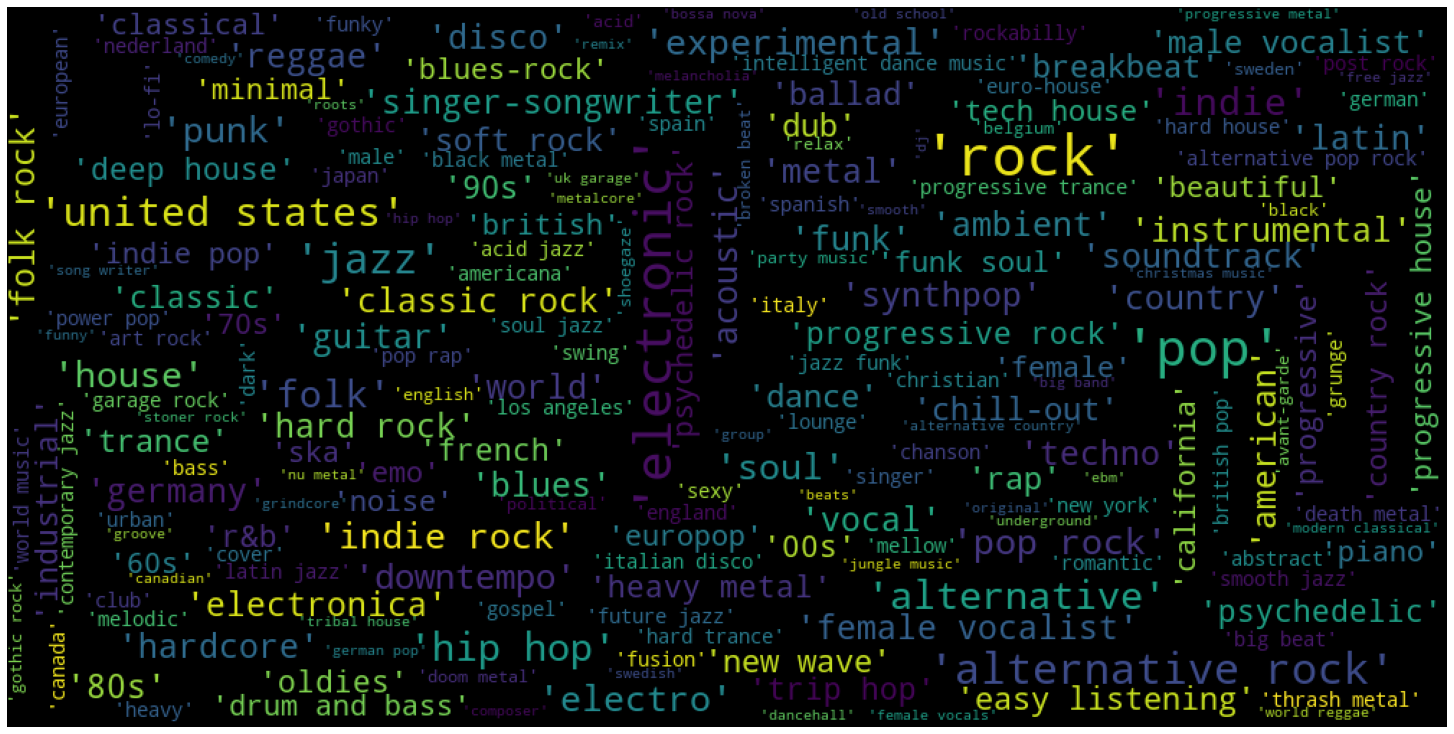

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=40, width =1000, height = 500)
wordcloud.fit_words(gen_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [45]:
plt.savefig('wordcloud.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [ ]:
spark.stop()